In [7]:
import gym
import numpy as np
import torch
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.nn.functional as F
from collections import deque
import random



from tqdm import tqdm

from ReplayBuffer import ReplayBuffer
from environment import Environment

In [8]:
device = T.device("cuda" if T.cuda.is_available() else "cpu")
print(device)

cpu


### env


In [9]:
# Define the Quadrotor Environment
class QuadrotorEnv(gym.Env):
    metadata = {'render.modes': ['console']}
 
    def __init__(self):
        super(QuadrotorEnv, self).__init__()
        self.g = 9.81  
        self.m = 1.0   
        self.mu = 0.05
        self.dt = 0.02
        self.action_space = gym.spaces.Box(low=np.array([0, -np.pi, -np.pi]), 
                                           high=np.array([20, np.pi, np.pi]), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32)
        self.reset()
 
    def step(self, action):
        T, phi, theta = action
        x, y, z, vx, vy, vz = self.state
        ax = (-0.7071 * np.cos(phi) * np.sin(theta) - 0.7071 * np.sin(phi)) * T / self.m
        ay = (-0.7071 * np.cos(phi) * np.sin(theta) - 0.7071 * np.sin(phi)) * T / self.m
        az = self.g - (np.cos(phi) * np.cos(theta)) * T / self.m
        vx += (ax - self.mu * vx) * self.dt
        vy += (ay - self.mu * vy) * self.dt
        vz += (az - self.mu * vz) * self.dt
 
        x += vx * self.dt
        y += vy * self.dt
        z += vz * self.dt
 
        self.state = np.array([x, y, z, vx, vy, vz])
        reward = -np.sqrt((x - 5 * np.cos(1.2 * self.current_step * self.dt))**2 + 
                          (y - 5 * np.sin(1.2 * self.current_step * self.dt))**2 + (z + 20)**2)
        done = z < -50 or self.current_step > 1000
        self.current_step += 1
        return self.state, reward, done, {}
 
    def reset(self):
        self.state = np.array([0.0, 0.0, 0.0, 1.0, -1.0, 0.0], dtype=np.float32)
        self.current_step = 0
        return self.state
 
    def render(self, mode='console'):
        if mode == 'console':
            print(f'State: {self.state}')

In [10]:
#intialise OUACTIONNOISE
class OUActionNoise(object):
    def __init__(self, mu, sigma=0.15, theta=0.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)


# intialise an actor neural network along with forward pass
class ActorNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, output_dims):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = output_dims
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1.bias.data, -f1, f1)
        self.bn1 = nn.LayerNorm(self.fc1_dims)

        # W_init = tf.random_normal_initializer(mean=0, stddev=0.3)
        # b_init = tf.constant_initializer(0.1)

        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        f3 = 0.003

        self.mu = nn.Linear(self.fc2_dims, self.n_actions)
        T.nn.init.uniform_(self.mu.weight.data, -f3, f3)
        T.nn.init.uniform_(self.mu.bias.data, -f3, f3)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.to(device)
        
    def forward(self, state):
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.bn2(self.fc2(x)))
        x= T.sigmoid(self.mu(x))
        y=x.clone()
        y[0]=x[0]*20
        y[1]=y[1]*2*T.pi
        y[2]=y[2]*T.pi
        # print(x.shape)
        # print(x)
        # Combine the outputs for each dimension
        return y

# intialise a critic neural network along with forward pass like above
class CriticNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims):
        super(CriticNetwork, self).__init__()
        self.input_dims_state = input_dims[0]
        self.input_dims_action = input_dims[1]
        # print(self.input_dims_state, self.input_dims_action)
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims


        self.fc1_state = nn.Linear(self.input_dims_state, self.fc1_dims)
        f1 = 1./np.sqrt(self.fc1_state.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1_state.weight.data, -f1, f1)
        T.nn.init.uniform_(self.fc1_state.bias.data, -f1, f1)
        self.bn1_state = nn.LayerNorm(self.fc1_dims)

        self.fc1_action = nn.Linear(self.input_dims_action, self.fc1_dims)
        f1_2 = 1./np.sqrt(self.fc1_action.weight.data.size()[0])
        T.nn.init.uniform_(self.fc1_action.weight.data, -f1_2, f1_2)
        T.nn.init.uniform_(self.fc1_action.bias.data, -f1_2, f1_2)
        self.bn1_action = nn.LayerNorm(self.fc1_dims)

        self.fc2 = nn.Linear(2*self.fc1_dims, self.fc2_dims)
        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        T.nn.init.uniform_(self.fc2.weight.data, -f2, f2)
        T.nn.init.uniform_(self.fc2.bias.data, -f2, f2)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        self.action_value = nn.Linear(self.fc2_dims,1)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.to(device)
        
    def forward(self, state, action):
        state_input = F.relu(self.bn1_state(self.fc1_state(state)))
        action_input = F.relu(self.bn1_action(self.fc1_action(action)))
        # print(state_input.shape, action_input.shape)
        # Concatenate state and action inputs
        x = T.cat((state_input, action_input), dim=1)
        
        # concatinate state and action into a new tensor
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.action_value(x)
        
        return x
    
# intialise the agent class
class DDPG_Agent(object):
    def __init__(self, alpha, beta, input_dims_actor,input_dims_critic,input_dims_buff,tau=0.9, gamma=0.99, n_actions=3, max_size=1000, layer1_size=40
                 , layer2_size=30, batch_size=64):
        self.gamma = gamma
        self.tau = tau
        self.memory = ReplayBuffer(max_size, input_dims_buff)
        self.batch_size = batch_size
        self.n_actions = n_actions
        self.actor = ActorNetwork(alpha,input_dims_actor, layer1_size, layer2_size, output_dims=n_actions)
        self.critic = CriticNetwork(beta,input_dims_critic, layer1_size, layer2_size)
        self.target_actor = ActorNetwork(alpha,input_dims_actor, layer1_size, layer2_size, output_dims=n_actions)
        self.target_critic = CriticNetwork(beta, input_dims_critic, layer1_size, layer2_size)
        
        self.noise = OUActionNoise(mu=np.zeros(n_actions))
        
        self.update_network_parameters(tau=1)
        
    def choose_action(self, observation):
        self.actor.eval()
        observation = T.tensor(observation, dtype=T.float).to(device)
        mu = self.actor.forward(observation).to(device)
        mu_prime = mu + T.tensor(self.noise(), 
                                 dtype=T.float).to(device)
        self.actor.train()
        return mu_prime.cpu().detach().numpy()
    
    def remember(self, state, action, reward, new_state, done):
        self.memory.add_sample(state, action, reward, new_state, done)
    
    def learn(self, num_step):
        if self.memory.count < self.batch_size:
            return
        
        states, actions, rewards, new_states, dones = self.memory.return_sample(self.batch_size)
        
        states = T.tensor(states, dtype=T.float).to(device)
        actions = T.tensor(actions, dtype=T.float).to(device)
        rewards = T.tensor(rewards, dtype=T.float).to(device)
        new_states = T.tensor(new_states, dtype=T.float).to(device)
        dones = T.tensor(dones).to(device)

        self.target_actor.eval()
        self.target_critic.eval()
        self.critic.eval()
        
        target_actions = self.target_actor.forward(new_states)
        # print(target_actions.shape)
        # print(new_states.shape)
        target_critics = self.target_critic.forward(new_states, target_actions)
        critic_value = self.critic.forward(states, actions)
        

        y = []
        for j in range(self.batch_size):
            y.append(rewards[j] + self.gamma*target_critics[j]*dones[j])
        y = T.tensor(y).to(device)
        y = y.view(self.batch_size, 1)
        self.critic.train()
        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(critic_value, y)
        critic_loss.backward()
        self.critic.optimizer.step()


        
       
        self.critic.eval()
        self.actor.eval()
        p = -self.critic.forward(states, self.actor.forward(states))
        self.actor.train()
        self.actor.optimizer.zero_grad()
        actor_loss = T.mean(p)
        actor_loss.backward()
        self.actor.optimizer.step()
        if num_step == 0:
            self.update_network_parameters()

        
    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_dict = dict(target_critic_params)
        target_actor_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + (1-tau)*target_critic_dict[name].clone()

        for name in actor_state_dict:
            actor_state_dict[name] = tau*actor_state_dict[name].clone() + (1-tau)*target_actor_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)
        self.target_actor.load_state_dict(actor_state_dict)



agent = DDPG_Agent(alpha=0.003, beta=0.003, input_dims_actor=[6], input_dims_critic=[6,3], input_dims_buff=[6,3], tau=0.03, gamma=0.9,batch_size=64, layer1_size=256, layer2_size=256, n_actions=3)
env = Environment(state = np.array([0, 1, 0, -1, 0, 0]), mu = 0.05, m = 1, g = 9.8, thetamin = 0, thetamax = np.pi, phimin = 0, phimax = 2*np.pi, Tmin = 0, Tmax = 20, dt = 0.02, dphi = 0.0175, dtheta = 0.0175)
np.random.seed(0)

Average_Rewards = []
for i in range(50):
    env.reset()
    done = False
    score = 0
    its = 0
    total_reward = []
    while not done and its<300:
        act = agent.choose_action(env.state)
        # print(act)
        state, new_state, reward, done = env.infostep(its,act)
        agent.remember(state, act, reward, new_state, int(done))
        agent.learn(its%18)
        total_reward.append(reward)
        its+=1
        
    tr = 0
    for r in total_reward[::-1]:
        tr = agent.gamma*tr + r
    # tr = tr/its 
    Average_Rewards.append(tr)

    print('episode ', i, 'score %.1f' % tr)





episode  0 score -209.1
episode  1 score -217.0
episode  2 score -217.8
episode  3 score -210.4
episode  4 score -202.3
episode  5 score -201.9
episode  6 score -202.1
episode  7 score -201.8
episode  8 score -202.1
episode  9 score -202.0
episode  10 score -202.1
episode  11 score -202.2
episode  12 score -202.0
episode  13 score -202.0
episode  14 score -202.2
episode  15 score -202.5
episode  16 score -202.1
episode  17 score -203.4
episode  18 score -202.5
episode  19 score -201.8
episode  20 score -201.7
episode  21 score -205.8
episode  22 score -201.8
episode  23 score -202.2
episode  24 score -202.7
episode  25 score -203.2
episode  26 score -203.8
episode  27 score -203.1
episode  28 score -201.9
episode  29 score -201.9
episode  30 score -202.4
episode  31 score -203.8
episode  32 score -203.5
episode  33 score -204.5
episode  34 score -205.0
episode  35 score -203.0
episode  36 score -202.1
episode  37 score -201.8
episode  38 score -203.3
episode  39 score -204.1
episode  4

### Neural networks

In [11]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, action_bound):
        super(Actor, self).__init__()
        self.layer1 = nn.Linear(state_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.mean = nn.Linear(256, action_dim)
        self.log_std = nn.Linear(256, action_dim)
        self.action_bound = action_bound
 
    def forward(self, state):
        # x = torch.relu(self.layer1(state))
        # x = torch.relu(self.layer2(x))
        # x = self.bn1(torch.relu(self.layer1(state)))
        # x = self.bn2(torch.relu(self.layer2(x)))
        x = torch.nn.functional.leaky_relu(self.layer1(state), 0.01)
        x = torch.nn.functional.leaky_relu(self.layer2(x), 0.01)
        mean = self.mean(x)
        log_std = self.log_std(x)

        
        log_std = torch.clamp(log_std, min=-1, max=1)


        std = torch.exp(log_std) + 1e-6  # Adding a small epsilon to avoid std = 0
        # print("Mean: ",mean)
        # print("State:", state)
        # print("std:  ", std)
        return mean, std
 
    def sample(self, state):
        # print("State:", state)
        mean, std = self.forward(state)
        normal = Normal(mean, std)
        z = normal.rsample()
        action = torch.tanh(z) * self.action_bound
        log_prob = normal.log_prob(z) - torch.log(1 - action.pow(2) + 1e-6)  # Enforcing action bounds
        log_prob = log_prob.sum(-1, keepdim=True)
        return action, log_prob

In [12]:
# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.layer1 = nn.Linear(state_dim + action_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.value = nn.Linear(256, 1)
 
    def forward(self, state, action):
        x = torch.cat([state, action], dim=1)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        value = self.value(x)
        return value
 


In [13]:
# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
 
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
 
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.array(state), np.array(action), np.array(reward, dtype=np.float32), np.array(next_state), np.array(done, dtype=np.float32)
 
    def __len__(self):
        return len(self.buffer)

In [14]:
# SAC Agent
class SACAgent:
    def __init__(self, state_dim, action_dim, action_bound):
        self.actor = Actor(state_dim, action_dim, action_bound).to(device)
        self.critic_1 = Critic(state_dim, action_dim).to(device)
        self.critic_2 = Critic(state_dim, action_dim).to(device)
        self.target_critic_1 = Critic(state_dim, action_dim).to(device)
        self.target_critic_2 = Critic(state_dim, action_dim).to(device)
        self.target_critic_1.load_state_dict(self.critic_1.state_dict())
        self.target_critic_2.load_state_dict(self.critic_2.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=3e-4)
        self.critic_optimizer = optim.Adam(list(self.critic_1.parameters()) + list(self.critic_2.parameters()), lr=3e-4)
        self.replay_buffer = ReplayBuffer(1000000)
        self.gamma = 0.99
        self.tau = 0.005
        self.alpha = 0.2
 
    def select_action(self, state):
        state = torch.FloatTensor(state).to(device)
        action, _ = self.actor.sample(state)
        return action.cpu().data.numpy()
 
    def update(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)
        state = torch.FloatTensor(state).to(device)
        action = torch.FloatTensor(action).to(device)
        reward = torch.FloatTensor(reward).to(device).unsqueeze(1)
        next_state = torch.FloatTensor(next_state).to(device)
        done = torch.FloatTensor(done).to(device).unsqueeze(1)
 
        with torch.no_grad():
            next_action, next_log_prob = self.actor.sample(next_state)
            target_Q1 = self.target_critic_1(next_state, next_action)
            target_Q2 = self.target_critic_2(next_state, next_action)
            target_Q = reward + (1 - done) * self.gamma * (torch.min(target_Q1, target_Q2) - self.alpha * next_log_prob)
 
        current_Q1 = self.critic_1(state, action)
        current_Q2 = self.critic_2(state, action)
        critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
 
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
 
        action_new, log_prob_new = self.actor.sample(state)
        Q1_new = self.critic_1(state, action_new)
        Q2_new = self.critic_2(state, action_new)
        actor_loss = (self.alpha * log_prob_new - torch.min(Q1_new, Q2_new)).mean()
        # Gradient clipping    
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1)
        torch.nn.utils.clip_grad_norm_(self.critic_1.parameters(), 1)
        torch.nn.utils.clip_grad_norm_(self.critic_2.parameters(), 1)
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
 
        # Soft update the target network
        for target_param, param in zip(self.target_critic_1.parameters(), self.critic_1.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
        for target_param, param in zip(self.target_critic_2.parameters(), self.critic_2.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
 

### training loop

In [15]:
# Main training loop
def train():
    env = QuadrotorEnv()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    action_bound = env.action_space.high[0]
    agent = SACAgent(state_dim, action_dim, action_bound)
    episodes = 100
    steps_per_episode = 1000
    batch_size = 256
    gradient_steps = 50
 
    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        for _ in range(steps_per_episode):
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward
            if done:
                break
#         for _ in range(gradient_steps):
#             agent.update(batch_size)
 
#         print(f'Episode: {episode}, Reward: {episode_reward}')
 
# if __name__ == '__main__':
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     train()

### Outputs

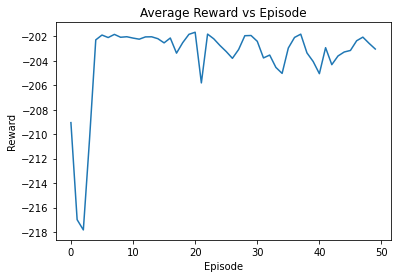

In [18]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(Average_Rewards)), Average_Rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Average Reward vs Episode')
plt.show()

In [19]:
def plot_trajectory(states):
    x = [state[0] for state in states]
    y = [state[2] for state in states]
    z = [state[4] for state in states]


    plt.subplot(1, 2, 1)
    plt.plot(x, y, 'r.-')
    plt.title('X vs Y')
    plt.xlabel('X')
    plt.ylabel('Y')

    # Plotting x vs z
    plt.subplot(1, 2, 2)
    plt.plot(z, 'g.-')
    plt.title(' Z')

    plt.tight_layout()
    plt.show()
def plot_actions(actions):
    T_values = [action[0] for action in actions]
    phi_values = [action[1] for action in actions]
    theta_values = [action[2] for action in actions]

    fig, axs = plt.subplots(3, 1, figsize=(10, 8))
    axs[0].plot(range(len(T_values)), T_values)
    axs[0].set_ylabel('T')
    axs[0].set_title('Trajectory of T')
    axs[0].set_ylim(env.Tmin, env.Tmax)

    axs[1].plot(range(len(phi_values)), phi_values)
    axs[1].set_ylabel('phi')
    axs[1].set_title('Trajectory of phi')
    axs[1].set_ylim(env.phimin, env.phimax)

    axs[2].plot(range(len(theta_values)), theta_values)
    axs[2].set_ylabel('theta')
    axs[2].set_title('Trajectory of theta')
    axs[2].set_ylim(env.thetamin, env.thetamax)

    plt.xlabel('Time Step')
    plt.tight_layout()
    plt.show()


168


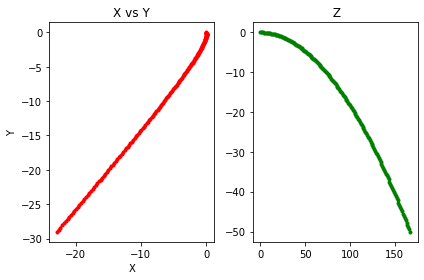

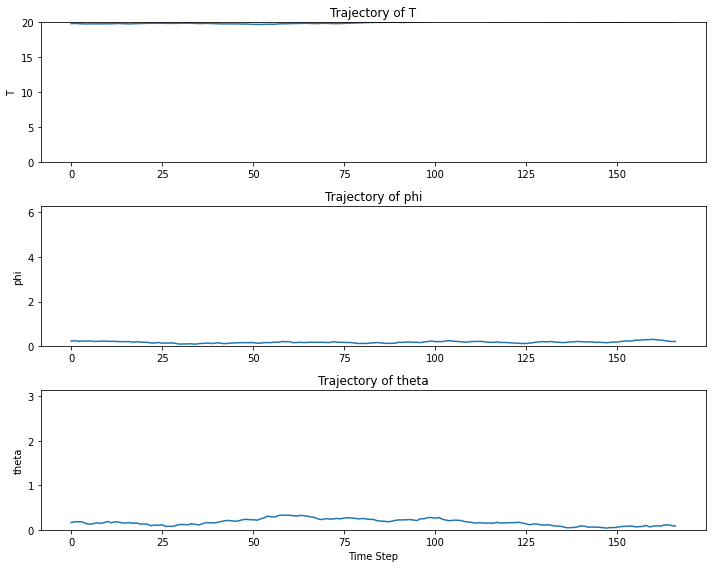

In [20]:
state = [0, 1, 0, -1, 0, 0]
done = False
score = 0
its = 0
states = []
actions = []
env.reset()
states.append(env.state)
while not done and its<30000:
    act = agent.choose_action(env.state)
    # print(act)
    actions.append(act)
    state,new_state, reward, done = env.infostep(its,act)
    states.append(env.state)
    score+=reward
    its+=1

print(len(states))

states = np.array(states)
actions = np.array(actions)
# save these two arrays to a file
np.save('states_DDPG.npy', states)
np.save('actions_DDPG.npy', actions)

plot_trajectory(states)
plot_actions(actions)